# Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

import catboost
import xgboost

In [3]:
import sklearn
from sklearn import set_config

In [4]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.4.1.post1


In [5]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [6]:
set_config(transform_output="pandas")

In [7]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [8]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [9]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [10]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.ipynb_checkpoints',
 'EDA and FE.ipynb',
 'Model.ipynb',
 'catboost_info',
 'input',
 'notebooks',
 'outputs',
 'requirements.txt',
 'requirements_py310.txt',
 'src',
 'venvs',
 'videos']

In [11]:
sys.path

['/opt/homebrew/Cellar/python@3.10/3.10.14/Frameworks/Python.framework/Versions/3.10/lib/python310.zip',
 '/opt/homebrew/Cellar/python@3.10/3.10.14/Frameworks/Python.framework/Versions/3.10/lib/python3.10',
 '/opt/homebrew/Cellar/python@3.10/3.10.14/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload',
 '',
 '/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages']

In [12]:
sys.path.insert(0, os.path.join(CWD, "src"))

In [13]:
from src import (
    SurnameExtractor,
    CabinLetterExtractor,
    CustomOrdinalEncoder
)

# Helper functions

In [14]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Data Loading

In [15]:
X_train, X_test = load_data()

<Axes: ylabel='Frequency'>

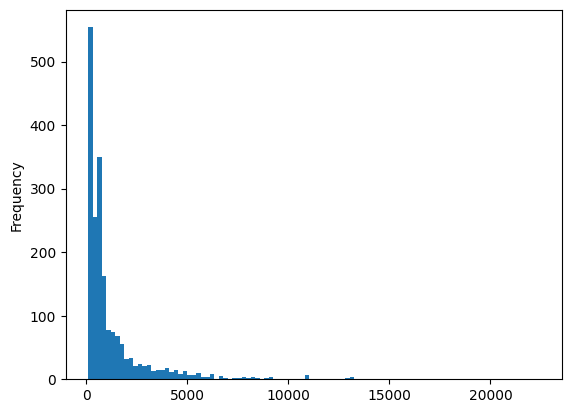

In [16]:
X_train[X_train["Spa"] > 100]["Spa"].plot(kind = "hist", bins = 100)

In [17]:
y = X_train.pop("Transported")

# Impute data with Pipelines

In [18]:
ct_impute = ColumnTransformer(
    transformers = [
        ("impute_numerical", SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'drop'
)

In [19]:
ct_impute

ColumnTransformer(transformers=[('impute_numerical', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16a846770>),
                                ('impute_cabin',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Cabin']),
                                ('impute_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Name'])])

# Preprocess Data Post Imputation

In [20]:
class MiddleLetterExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X["impute_cabin__Cabin"].apply(
            lambda cabin: 2000 if cabin == "NA" else float(cabin.split("/")[1])
        ).to_frame()

In [21]:
mle = MiddleLetterExtractor()

In [22]:
pipe_mle = Pipeline(
    steps = [
        ("mle", MiddleLetterExtractor()),
        ("fu_mle", FeatureUnion(
            transformer_list = [
                ("kbins_20", KBinsDiscretizer(n_bins = 20, strategy = "uniform", encode = "ordinal")),
                ("kbins_50", KBinsDiscretizer(n_bins = 50, strategy = "uniform", encode = "ordinal")),
                ("kbins_100", KBinsDiscretizer(n_bins = 100, strategy = "uniform", encode = "ordinal"))
            ]
        ))   
    ]
)

TO DO: define an EmbeddingTransfomer compatible with scikit-learn

https://medium.com/@micahmelling/categorical-embeddings-in-scikit-learn-pipeline-c81071be5140

In [23]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_buckets", KBinsDiscretizer(encode = "ordinal", strategy = "uniform", n_bins = 8)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [24]:
fu_cabin = FeatureUnion(
    transformer_list = [
        ("extract_first_letter", CabinLetterExtractor(letter="first")),
        ("extract_last_letter", CabinLetterExtractor(letter="last"))
    ]
)

In [25]:
fe_cabin = Pipeline(
    steps = [
        ("extract_letters_from_cabin", fu_cabin),
        ("ohe_first_letter", OneHotEncoder(sparse_output=False)),
    ]
)

In [26]:
# We are getting all the surnames that exist in train and test
# because our CustomOrdinalEncoder can faill when doing CV
# or when predicting test
surnames_ = pd.concat([X_train[["Name"]], X_test[["Name"]]]).dropna()

In [27]:
SURNAMES = SurnameExtractor().fit_transform(surnames_).values

In [28]:
fe_surname = Pipeline(
    steps = [
        ("extract_surname", SurnameExtractor()),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(list_surnames=SURNAMES))
    ]
)

In [29]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("pass", "passthrough", [1, 2, 3, 4, 5]),
        ("fe_cabin", fe_cabin, ["impute_cabin__Cabin"]),
        ("mle", pipe_mle, ["impute_cabin__Cabin"]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        ),
        ("oe", OrdinalEncoder(), ["impute_categorical__Destination"]),
        ("surname", fe_surname, ["impute_categorical__Name"])
    ],
    remainder = "passthrough"
)

In [30]:
def drop_duplicated_columns(X):
    return X.iloc[:, ~X.columns.duplicated()]

In [31]:
def get_pipe_without_model():
    
    pipe = Pipeline(
        steps = [
            ("impute", ct_impute),
            ("fe", ct_fe),
            ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
        ]
    )
    
    return pipe

In [32]:
def get_pipe(model = None):
    
    if model is None:
        return get_pipe_without_model()
    
    else:
        
        pipe = Pipeline(
            steps = [
                ("impute", ct_impute),
                ("fe", ct_fe),
                ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
                ("model", model)
            ]
        )
    
        return pipe

In [56]:
model = VotingClassifier(
    estimators = [
        ("xgboost", xgboost.XGBClassifier()),
        ("catboost", catboost.CatBoostClassifier()),
        ("hgb", HistGradientBoostingClassifier()),
        ("rf", RandomForestClassifier())
    ]
)

model = HistGradientBoostingClassifier()
model = catboost.CatBoostClassifier()
model = xgboost.XGBClassifier()

In [54]:
pipe = get_pipe(model = model)

In [55]:
pipe

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16a846770>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destinatio...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [36]:
# cv_scores = cross_val_score(estimator=pipe, X=X_train, y=y, cv=10, n_jobs = -1)

# cv_scores

# np.mean(cv_scores)

# np.std(cv_scores)

# Model Explainability

In [41]:
def get_fi(model):
    
    if isinstance(model, catboost.CatBoostClassifier):
        return model.get_feature_importance()
    
    elif isinstance(model, xgboost.XGBClassifier):
        return model.feature_importances_

In [42]:
def create_fi_df(model, X):
    
    fi = get_fi(model = model)
    fn = X.columns
    
    fidf = pd.DataFrame(
        data  = [
            fn,
            fi
        ]
    ).T
    
    fidf.rename(
        columns = {
            0:"FeatureName",
            1:"FeatureImportance"
        },
        inplace = True
    )
    
    return fidf.sort_values("FeatureImportance", ascending = False)

In [59]:
def run_experiment(model, X_train, y):
    
    pipe = get_pipe(model = model)
    
    cv_scores = cross_val_score(
        estimator = pipe,
        X = X_train,
        y = y,
        cv = 10,
        n_jobs = -1,
        scoring = "accuracy"
    )
    
    print(str(model))
    print(cv_scores)
    print(f"Mean: {np.mean(cv_scores)}")
    print(f"Std: {np.std(cv_scores)}")
    
    Xt = pipe[:-1].fit_transform(X_train)
    pipe.fit(X_train, y)
    model_fitted = pipe[-1]
    
    try:
        fidf = create_fi_df(model = model_fitted, X = Xt)
    except:
        fidf = None
    
    return pipe, cv_scores, Xt, model_fitted, fidf

In [60]:
pipe_xgb, cv_scores_xgb, Xt_xgb, model_fitted_xgb, fidf_xgb = run_experiment(
    model = xgboost.XGBClassifier(),
    X_train = X_train,
    y = y
)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 wi

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopesc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
[0.77241379 0.72643678 0.74597701 0.72842348 0.74913694 0.81012658
 0.83314154 0.81012658 0.7986191  0.7456847 ]
Mean: 0.772008650450379
Std: 0.036361571669181816


In [61]:
fidf_xgb

,FeatureName,FeatureImportance
26,ohe__impute_categorical__CryoSleep_False,0.412891
23,ohe__impute_categorical__HomePlanet_Earth,0.102821
0,fu_age__fe_age_12__impute_numerical__Age,0.08841
24,ohe__impute_categorical__HomePlanet_Europa,0.051835
13,fe_cabin__impute_cabin__Cabin_E,0.030845
19,fe_cabin__impute_cabin__Cabin_S,0.024092
7,pass__impute_numerical__Spa,0.023436
8,pass__impute_numerical__VRDeck,0.021674
4,pass__impute_numerical__RoomService,0.018187
5,pass__impute_numerical__FoodCourt,0.016798


In [62]:
pipe_cat, cv_scores_cat, Xt_cat, model_fitted_cat, fidf_cat = run_experiment(
    model = catboost.CatBoostClassifier(verbose = 0),
    X_train = X_train,
    y = y
)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 wi

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sk

[0.77126437 0.75977011 0.74827586 0.73532796 0.75143843 0.82508631
 0.84695052 0.82393556 0.81703107 0.75489068]
Mean: 0.7833970874171661
Std: 0.03825596757941712


In [63]:
fidf_cat

,FeatureName,FeatureImportance
7,pass__impute_numerical__Spa,10.295703
8,pass__impute_numerical__VRDeck,9.650705
4,pass__impute_numerical__RoomService,7.255223
27,ohe__impute_categorical__CryoSleep_True,7.024902
5,pass__impute_numerical__FoodCourt,6.412977
3,fu_age__fe_age_pass__impute_numerical__Age,5.346081
22,mle__kbins_100__impute_cabin__Cabin,5.221433
23,ohe__impute_categorical__HomePlanet_Earth,5.176273
31,surname__x0,4.91672
26,ohe__impute_categorical__CryoSleep_False,4.491194


In [67]:
model = VotingClassifier(
    estimators = [
        ("xgboost", xgboost.XGBClassifier(verbose = False)),
        ("catboost", catboost.CatBoostClassifier(verbose = 0)),
        ("hgb", HistGradientBoostingClassifier()),
        ("rf", RandomForestClassifier())
    ]
)

In [68]:
model

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x16d424bb0>),
                             ('hgb', HistGradientBoostingClassifier()),
                             ('rf', RandomForestClassifier())])

In [69]:
pipe_vc, cv_scores_vc, Xt_vc, model_fitted_vc, fidf_vc = run_experiment(
    model = model,
    X_train = X_train,
    y = y
)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 wi

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 wi

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            max_cat_to_onehot=None,
    

# Submission a Kaggle

In [72]:
pipe = pipe_vc

In [73]:
y_pred = pipe.predict(X_test)

In [75]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
timestamp

'2024_04_21_20_19_48'

In [76]:
X_test_copy = X_test.copy(deep = True)

In [77]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [78]:
if not KAGGLE:
    path_export = os.path.join(CWD, "outputs", f"submission_{timestamp}.csv")
else:
    path_export = f"submission_{timestamp}.csv"

In [79]:
(
    X_test_copy
    .reset_index()
    [["PassengerId", "Transported"]]
    .to_csv(path_export, index=False)
)

In [80]:
# Benchmark -                        0.7234581961033293
# New Model con OHE -                0.7155214740155814
# New Model con 4 depth -            0.764529582159438
# Model with 4 depth y CabinFe -     0.7709713900242054
# HistGradient default params y -    0.7998441860772721
# HistGradient default params y -    0.8028344113328835  # Leaderboard - 1359
# default pipe + OE de Destionation

# HistGradient default params y -    0.8036411253521687  # Leaderboard - 1359 - 0.79331
# default pipe + OE de Destionation
# First and Last letter de Cabin

# HistGradient default params y -    0.8043334259222517 # Leaderboard -  1093 - 0.79682
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.799844450617039 # Leaderboard -  985 - 0.79822
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.8023753025673586 # Leaderboard -  965 - 0.79869
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder
# KBinsDiscretizer + Age

# Pipe with VotingClassifier        0.800306601589884   # Leaderboard - 966 - 0.79518
# 4 models: cat, xgb, hgb, rf

# Pipe with Catboost                
# 20, 50, 100 KBinsDiscretizar Cabin 0.7833970874171661 # Leaderboard - 744 - 0.80149

# Pipe with VotingClassfier (cat, xgb, rf, hgb)               
# 20, 50, 100 KBinsDiscretizar Cabin 0.7830545084189782 # Leaderboard - 672 - 0.80243

581:	learn: 0.3145434	total: 4.33s	remaining: 3.11s
582:	learn: 0.3144033	total: 4.33s	remaining: 3.1s
583:	learn: 0.3142028	total: 4.34s	remaining: 3.09s
584:	learn: 0.3140116	total: 4.35s	remaining: 3.08s
585:	learn: 0.3139218	total: 4.36s	remaining: 3.08s
586:	learn: 0.3137833	total: 4.37s	remaining: 3.07s
587:	learn: 0.3136748	total: 4.38s	remaining: 3.07s
588:	learn: 0.3135602	total: 4.38s	remaining: 3.06s
589:	learn: 0.3133859	total: 4.39s	remaining: 3.05s
590:	learn: 0.3132463	total: 4.39s	remaining: 3.04s
591:	learn: 0.3131871	total: 4.39s	remaining: 3.03s
592:	learn: 0.3130795	total: 4.41s	remaining: 3.02s
593:	learn: 0.3129274	total: 4.41s	remaining: 3.02s
594:	learn: 0.3128303	total: 4.42s	remaining: 3.01s
595:	learn: 0.3127182	total: 4.42s	remaining: 3s
596:	learn: 0.3125643	total: 4.43s	remaining: 2.99s
597:	learn: 0.3124709	total: 4.43s	remaining: 2.98s
598:	learn: 0.3123293	total: 4.44s	remaining: 2.97s
599:	learn: 0.3121202	total: 4.45s	remaining: 2.96s
600:	learn: 0.31

842:	learn: 0.2958255	total: 6.04s	remaining: 1.12s
843:	learn: 0.2957302	total: 6.04s	remaining: 1.12s
844:	learn: 0.2956667	total: 6.05s	remaining: 1.11s
845:	learn: 0.2955153	total: 6.05s	remaining: 1.1s
846:	learn: 0.2954142	total: 6.07s	remaining: 1.1s
847:	learn: 0.2952955	total: 6.08s	remaining: 1.09s
848:	learn: 0.2952452	total: 6.08s	remaining: 1.08s
849:	learn: 0.2951212	total: 6.08s	remaining: 1.07s
850:	learn: 0.2950388	total: 6.09s	remaining: 1.06s
851:	learn: 0.2950063	total: 6.1s	remaining: 1.06s
852:	learn: 0.2948793	total: 6.1s	remaining: 1.05s
853:	learn: 0.2948249	total: 6.11s	remaining: 1.04s
854:	learn: 0.2947100	total: 6.13s	remaining: 1.04s
855:	learn: 0.2946478	total: 6.16s	remaining: 1.03s
856:	learn: 0.2945907	total: 6.16s	remaining: 1.03s
857:	learn: 0.2944938	total: 6.17s	remaining: 1.02s
858:	learn: 0.2943606	total: 6.17s	remaining: 1.01s
859:	learn: 0.2942788	total: 6.19s	remaining: 1.01s
860:	learn: 0.2941949	total: 6.19s	remaining: 1000ms
861:	learn: 0.2

582:	learn: 0.3262231	total: 4.21s	remaining: 3.01s
583:	learn: 0.3260601	total: 4.22s	remaining: 3s
584:	learn: 0.3259558	total: 4.22s	remaining: 3s
585:	learn: 0.3258236	total: 4.23s	remaining: 2.99s
586:	learn: 0.3257112	total: 4.23s	remaining: 2.98s
587:	learn: 0.3256389	total: 4.24s	remaining: 2.97s
588:	learn: 0.3255501	total: 4.25s	remaining: 2.96s
589:	learn: 0.3254083	total: 4.25s	remaining: 2.95s
590:	learn: 0.3252631	total: 4.26s	remaining: 2.95s
591:	learn: 0.3251237	total: 4.26s	remaining: 2.94s
592:	learn: 0.3249351	total: 4.27s	remaining: 2.93s
593:	learn: 0.3248094	total: 4.28s	remaining: 2.92s
594:	learn: 0.3246623	total: 4.28s	remaining: 2.91s
595:	learn: 0.3245234	total: 4.3s	remaining: 2.92s
596:	learn: 0.3243740	total: 4.31s	remaining: 2.91s
597:	learn: 0.3242251	total: 4.32s	remaining: 2.9s
598:	learn: 0.3240948	total: 4.32s	remaining: 2.89s
599:	learn: 0.3240156	total: 4.33s	remaining: 2.89s
600:	learn: 0.3238056	total: 4.34s	remaining: 2.88s
601:	learn: 0.323612

# The End